In [3]:
import casadi as ca
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
from step_wise_implementation.step_size_control import refineSolution, reduceIntervalBy2

### Time discretization implementation of pce solver

In [4]:
def plot_pce_trajectories(res, t_grid, pce_order, k_mean, k_std, s_mean, s_std):
    N = len(t_grid) - 1
    x = res['x']    # shape: (M, N+1)
    h = res['h']
    V = res['V']
    M = x.shape[0]

    print(f"minimum altitude: {np.min(h):4f} ft")
    
    k_dist = cp.Normal(k_mean, k_std)
    s_dist = cp.Normal(s_mean, s_std)
    joint_dist = cp.J(k_dist, s_dist)
    
    nodes, _ = cp.generate_quadrature(pce_order, joint_dist, rule='G')
    
    M = nodes.shape[1]
    # print(f'Number of PCE nodes: {M}')

    plt.figure(figsize=(12,5))

    # h-x plot
    plt.subplot(1,2,1)
    for j in range(M):
        k_val, s_val = nodes[:, j]
        plt.plot(x[j], h[j], label=f's={s_val:.3f}, k={k_val/np.sqrt(s_val):.3f}')
        
    plt.xlabel('Horizontal Position x [ft]')
    plt.ylabel('Altitude h [ft]')
    plt.title('Altitude vs. Horizontal Position')
    plt.grid(True)
    plt.legend()

    # V-t plot
    plt.subplot(1,2,2)
    for i in range(M):
        k_val, s_val = nodes[:, i]
        plt.plot(t_grid, V[i], label=f's={s_val:.3f}, k={k_val/np.sqrt(s_val):.3f}')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity V [ft/s]')
    plt.title('Velocity vs. Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
def solve_wider_wind_ocp_pce(t_grid, pce_order, k_mean, k_std, s_mean, s_std):
    N = len(t_grid) - 1

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    k_dist = cp.Normal(k_mean, k_std)
    s_dist = cp.Normal(s_mean, s_std)
    joint_dist = cp.J(k_dist, s_dist)
    
    poly_basis = cp.expansion.stieltjes(pce_order, joint_dist)
    nodes, weights = cp.generate_quadrature(pce_order, joint_dist, rule='G')
    # print(poly_basis.shape)     # ((pce_order+1)(pce_order+2)/2, )
    # print(weights.shape)        # ((pce_order+1)^2, )
    # print(nodes.shape)          # (2, (pce_order+1)^2)
    
    M = nodes.shape[1]              # number of PCE samples
    
    weights_dm = ca.DM(weights)   # ((pce_order+1)^2， )
    
    Psi_mat = poly_basis(*nodes)    # (M_poly_basis, (pce_order+1)^2)
    Psi_dm = ca.DM(Psi_mat)         # (M_poly_basis, (pce_order+1)^2)
    

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(M, N+1)
    h_s = opti.variable(M, N+1)
    V_s = opti.variable(M, N+1)
    gamma_s = opti.variable(M, N+1)
    alpha_s = opti.variable(M, N+1)
    X_pce = opti.variable(5*(pce_order+1), N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_, s_):
        A1 = -50 + a * (x_/s_)**3 + b * (x_/s_)**4
        A2 = 0.025 * ((x_/s_) - 2300)
        A3 = 50 - a * (4600 - (x_/s_))**3 - b * (4600 - (x_/s_))**4
        A4 = 50
        s1 = Smooth(x_, 480 * s_, 520 * s_)
        s2 = Smooth(x_, 4080 * s_, 4120 * s_)
        s3 = Smooth(x_, 4580 * s_, 4620 * s_)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500 * s_, B12,
               ca.if_else(x_ <= 4100 * s_, B23,
               ca.if_else(x_ <= 4600 * s_, B34, A4)))

    def B_piecewise(x_, s_):
        B1 = d * (x_/s_)**3 + e * (x_/s_)**4
        B2 = -51 * ca.exp(ca.fmin(-c * ((x_/s_) - 2300)**4, 30))
        B3 = d * (4600 - (x_/s_))**3 + e * (4600 - (x_/s_))**4
        B4 = 0
        s1 = Smooth(x_, 480 * s_, 520 * s_)
        s2 = Smooth(x_, 4080 * s_, 4120 * s_)
        s3 = Smooth(x_, 4580 * s_, 4620 * s_)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500 * s_, B12,
               ca.if_else(x_ <= 4100 * s_, B23,
               ca.if_else(x_ <= 4600 * s_, B34, B4)))

    def wind_x(x_, k_, s_):
        return k_ * A_piecewise(x_, s_)

    def wind_h(x_, h_, k_, s_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_, s_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_):
        return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    k_sym = ca.MX.sym("k")
    s_sym = ca.MX.sym("s")
    Wx_expr = wind_x(x_sym, k_sym, s_sym)
    Wh_expr = wind_h(x_sym, h_sym, k_sym, s_sym)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym, s_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym, s_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym, s_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_, k_val, s_val):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2

        Wx = wind_x(x_, k_val, s_val)
        Wh = wind_h(x_, h_, k_val, s_val)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_, k_val, s_val)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_, k_val, s_val)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_, k_val, s_val)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt, k_val, s_val):
        k1 = f(xk, uk, tk, k_val, s_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val, s_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val, s_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val, s_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    J = 0

    # Initial conditions
    opti.subject_to(x_s[:, 0] == 0)
    opti.subject_to(h_s[:, 0] == 600 / hscale)
    opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
    opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
    opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
    # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)
    opti.subject_to(gamma_s[:, -1] >= 0)
    
    h_ddot_all = [[] for _ in range(N)]
    
    for j in range(M):
        k_org, s_val = nodes[:, j]
        k_val = k_org / np.sqrt(s_val)  # Adjust k_val for PCE scaling

        for i in range(N):
            tk = t_grid[i]
            dt = t_grid[i + 1] - t_grid[i]

            h_physical = h_s[:, i] * hscale
            h_mean = ca.dot(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * h_physical)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            
            # h_ddot = d^2h/dt^2 = V_dot * sin(gamma) + V * cos(gamma) * gamma_dot + Wh_dot
            ode_out = aircraft_ode(Xk, Uk, tk, k_val, s_val)
            x_dot_k = ode_out[0]
            h_dot_k = ode_out[1]
            V_dot_k = ode_out[2]
            gamma_dot_k = ode_out[3]
            # alpha_dot_k = ode_out[4]
            
            dWh_dx_val = dWh_dx_fun(Xk[0], Xk[1], k_val, s_val)[0]
            dWh_dh_val = dWh_dh_fun(Xk[0], Xk[1], k_val, s_val)[0]
            Wh_dot_k = dWh_dx_val * x_dot_k + dWh_dh_val * h_dot_k
            
            h_ddot_k = V_dot_k * ca.sin(Xk[3]) + Xk[2] * ca.cos(Xk[3]) * gamma_dot_k + Wh_dot_k
            
            h_ddot_all[i].append(h_ddot_k)
            
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val, s_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

            alpha_i = alpha_s[:, i] * alphascale
            alpha_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * alpha_i)
            alpha_high_coeffs = alpha_pce_coeffs[1:]
            alpha_mean = ca.dot(weights_dm, alpha_i)
            std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

        opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
        opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)
            
    for i in range(N):
        h_ddot_vec = ca.vertcat(*h_ddot_all[i])
        h_ddot_pce_coeffs = ca.mtimes(Psi_dm, weights_dm * h_ddot_vec)
        h_ddot_mean = h_ddot_pce_coeffs[0]
        h_ddot_high_coeffs = h_ddot_pce_coeffs[1:]
        h_ddot_std_term = ca.sqrt(ca.sumsqr(h_ddot_high_coeffs))
        
        opti.subject_to(h_ddot_mean + 3 * h_ddot_std_term <= 10 * g)
        opti.subject_to(h_ddot_mean - 3 * h_ddot_std_term >= -2 * g)


    # # Cost function
    # J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    for j in range(M):
        opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
        opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
        opti.set_initial(V_s[j, :], 239.7 / Vscale)
        opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
        opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opts = {
        "expand": True,
        "ipopt": {
            # "max_iter": 3000,
            "max_cpu_time": 120,
            "tol": 1e-6,
            "print_level": 0,
            "linear_solver": "mumps",
            "hessian_approximation": "limited-memory",
            # "bound_push": 1e-8,
            # "bound_frac": 1e-8
        }
    }
    opti.solver("ipopt", opts)

    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        print(e)
        return {
            "x": opti.debug.value(x),
            "h": opti.debug.value(h),
            "V": opti.debug.value(V),
            "gamma": opti.debug.value(gamma),
            "alpha": opti.debug.value(alpha),
            "u": opti.debug.value(u),
            "J": opti.debug.value(J),
            "status": "failed"
        }

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
        "status": "success"
    }

In [6]:
tf = 100
N = 100
t_grid = np.linspace(0, tf, N + 1)
res = solve_wider_wind_ocp_pce(t_grid=t_grid, pce_order=1,
                               k_mean=1.0, k_std=0.25,
                               s_mean=1.0, s_std=0.1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  18.53ms ( 59.57us)  18.61ms ( 59.83us)       311
       nlp_g  |   2.37 s (  7.62ms)   2.38 s (  7.66ms)       311
  nlp_grad_f  |  29.43ms (126.87us)  29.60ms (127.58us)       232
   nlp_jac_g  |   9.40 s ( 40.53ms)   9.45 s ( 40.72ms)       232
       total  |  22.40 s ( 22.40 s)  22.52 s ( 22.52 s)         1


minimum altitude: 61.502383 ft


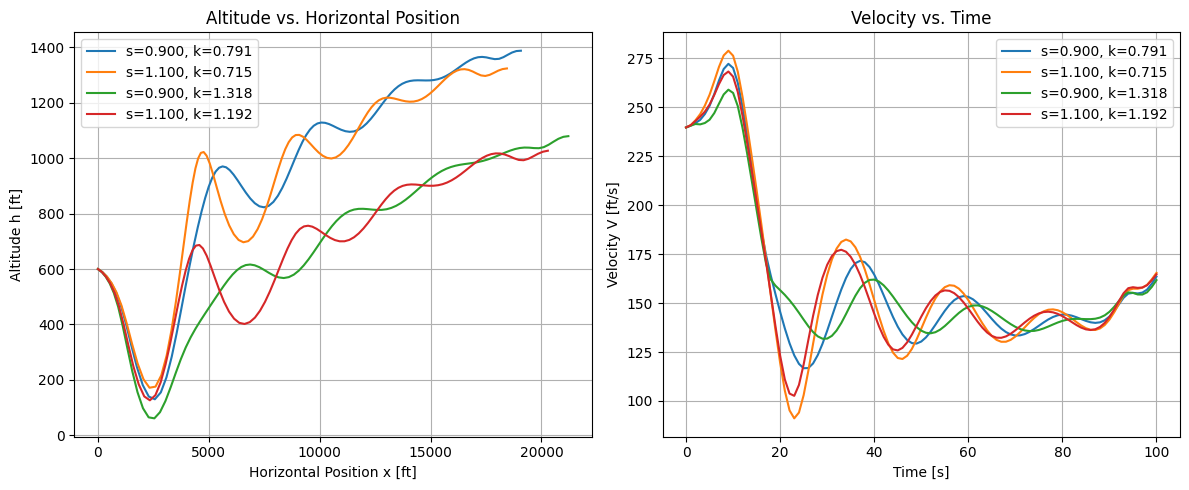

In [7]:
tf = 100
N = 100
t_grid = np.linspace(0, tf, N + 1)
plot_pce_trajectories(res, t_grid=t_grid, pce_order=1, 
                      k_mean=1.0, k_std=0.25, 
                      s_mean=1.0, s_std=0.1)

### Performance on smoothed wind model

In [8]:
def plot_trajectories(solutions, t_grids, k_val, s_val):
        
    plt.figure(figsize=(12,5))

    # h-x plot
    plt.subplot(1,2,1)
    for i in range(len(solutions)):
        sol = solutions[i]
        t_grid = t_grids[i]
        x = sol['x'] 
        h = sol['h']
        print(f"Solution {i+1} minimum altitude: {np.min(h):4f} ft")
        plt.plot(x, h, label=f'solution {i}')
        
    plt.xlabel('Horizontal Position x [ft]')
    plt.ylabel('Altitude h [ft]')
    plt.title('Altitude vs. Horizontal Position')
    plt.grid(True)
    plt.legend()

    # V-t plot
    plt.subplot(1,2,2)
    for i in range(len(solutions)):
        sol = solutions[i]
        t_grid = t_grids[i]
        V = sol['V']
        plt.plot(t_grid, V, label=f'solution {i}')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity V [ft/s]')
    plt.title('Velocity vs. Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def solve_ocp(t_grid, k_value, s_value):
    N = len(t_grid) - 1
    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(N+1)
    h_s = opti.variable(N+1)
    V_s = opti.variable(N+1)
    gamma_s = opti.variable(N+1)
    alpha_s = opti.variable(N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_, s_):
        A1 = -50 + a * (x_/s_)**3 + b * (x_/s_)**4
        A2 = 0.025 * ((x_/s_) - 2300)
        A3 = 50 - a * (4600 - (x_/s_))**3 - b * (4600 - (x_/s_))**4
        A4 = 50
        s1 = Smooth(x_, 480 * s_, 520 * s_)
        s2 = Smooth(x_, 4080 * s_, 4120 * s_)
        s3 = Smooth(x_, 4580 * s_, 4620 * s_)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500 * s_, B12,
               ca.if_else(x_ <= 4100 * s_, B23,
               ca.if_else(x_ <= 4600 * s_, B34, A4)))

    def B_piecewise(x_, s_):
        B1 = d * (x_/s_)**3 + e * (x_/s_)**4
        B2 = -51 * ca.exp(ca.fmin(-c * ((x_/s_) - 2300)**4, 30))
        B3 = d * (4600 - (x_/s_))**3 + e * (4600 - (x_/s_))**4
        B4 = 0
        s1 = Smooth(x_, 480 * s_, 520 * s_)
        s2 = Smooth(x_, 4080 * s_, 4120 * s_)
        s3 = Smooth(x_, 4580 * s_, 4620 * s_)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500 * s_, B12,
               ca.if_else(x_ <= 4100 * s_, B23,
               ca.if_else(x_ <= 4600 * s_, B34, B4)))

    def wind_x(x_, k_, s_):
        return k_ * A_piecewise(x_, s_)

    def wind_h(x_, h_, k_, s_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_, s_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_):
        return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x(x_sym, k_value, s_value)
    Wh_expr = wind_h(x_sym, h_sym, k_value, s_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        
        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2
        
        Wx = wind_x(x_, k_value, s_value)
        Wh = wind_h(x_, h_, k_value, s_value)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt):
        k1 = f(xk, uk, tk)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
        k4 = f(xk + dt * k3, uk, tk + dt)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # Initial conditions
    opti.subject_to(x_s[0] == 0)
    opti.subject_to(h_s[0] == 600 / hscale)
    opti.subject_to(V_s[0] == 239.7 / Vscale)
    opti.subject_to(V_s[:] >= 1e-2 / Vscale)
    opti.subject_to(gamma_s[0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[0] == min(0.1283, alphascale) / alphascale)
    opti.subject_to(gamma_s[-1] == -0.05236 / gammascale)

    for i in range(N):
        tk = t_grid[i]
        dt = t_grid[i + 1] - t_grid[i]

        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt)
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        opti.subject_to(X_next == Xk_end)
        opti.subject_to(opti.bounded(-1, u_s[i], 1))
        opti.subject_to(opti.bounded(-1, alpha_s[i], 1))

    # Cost function
    J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    opti.set_initial(x_s, ca.linspace(0, 1, N+1))
    opti.set_initial(h_s, 0.6)
    opti.set_initial(V_s, 239.7 / Vscale)
    opti.set_initial(gamma_s, -0.01 / gammascale)
    opti.set_initial(alpha_s, 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opti.solver("ipopt", {"expand": True}, {
        "max_iter": 1000,
        "tol": 1e-6,
        "print_level": 0,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory",
    })

    try:
        # opti.callback(lambda i: print("Alpha max:", np.max(opti.debug.value(alpha_s))))
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        raise e

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }

In [10]:
k_values = [1, 1.3]
s_values = [1, 0.9]
tf = 50

tol = 0.1
order = 4
max_iterations = 5

N_init = 20
t_grid_init = np.linspace(0, tf, N_init)

N_old = N_init
N_new = N_init
iteration = 0
t_grid_new = t_grid_init

while iteration < max_iterations and not (N_old == N_new and iteration != 0):
    N_old = N_new
    t_grid_old = t_grid_new
    res_old = []
    for i in range(len(k_values)):
        res_old_entry = solve_ocp(t_grid_old, k_values[i], s_values[i])
        res_old.append(res_old_entry)

    t_grid_compare = reduceIntervalBy2(t_grid_old)
    res_compare = []
    for i in range(len(k_values)):
        res_compare_entry = solve_ocp(t_grid_compare, k_values[i], s_values[i])
        res_compare.append(res_compare_entry)

    t_grid_new = refineSolution(res_old, res_compare, t_grid_old, t_grid_compare, tol=tol, p=order)
    N_new = len(t_grid_new)
    print('N_old: ', N_old)
    print('N_new: ', N_new)
    print("\n")
    iteration += 1

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 181.00us (  3.29us) 155.90us (  2.83us)        55
       nlp_g  |  15.76ms (286.56us)  15.65ms (284.53us)        55
  nlp_grad_f  | 174.00us (  4.35us) 171.87us (  4.30us)        40
   nlp_jac_g  |  61.86ms (  1.55ms)  61.95ms (  1.55ms)        40
       total  | 247.21ms (247.21ms) 247.80ms (247.80ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 221.00us (  3.30us) 220.69us (  3.29us)        67
       nlp_g  |  19.10ms (285.10us)  18.97ms (283.14us)        67
  nlp_grad_f  | 185.00us (  4.74us) 172.01us (  4.41us)        39
   nlp_jac_g  |  63.81ms (  1.64ms)  63.92ms (  1.64ms)        39
       total  | 256.20ms (256.20ms) 256.20ms (256.20ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 215.00us (  4.30us) 189.49us (  3.79us)        50
       nlp_g  |  27.55ms (550.96us)  27.45ms (549.07us)        50
  nlp_grad

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 412.00us (  5.28us) 383.09us (  4.91us)        78
       nlp_g  | 111.66ms (  1.43ms) 111.61ms (  1.43ms)        78
  nlp_grad_f  | 648.00us (  9.67us) 611.79us (  9.13us)        67
   nlp_jac_g  | 553.58ms (  8.26ms) 553.89ms (  8.27ms)        67
       total  |   1.69 s (  1.69 s)   1.69 s (  1.69 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.45ms ( 14.08us)   1.38ms ( 13.41us)       103
       nlp_g  | 793.21ms (  7.70ms) 793.28ms (  7.70ms)       103
  nlp_grad_f  |   3.43ms ( 36.45us)   3.37ms ( 35.82us)        94
   nlp_jac_g  |   4.24 s ( 45.08ms)   4.24 s ( 45.09ms)        94
       total  |  11.11 s ( 11.11 s)  11.11 s ( 11.11 s)         1
Solution 1 minimum altitude: 502.302309 ft
Solution 2 minimum altitude: 503.621394 ft


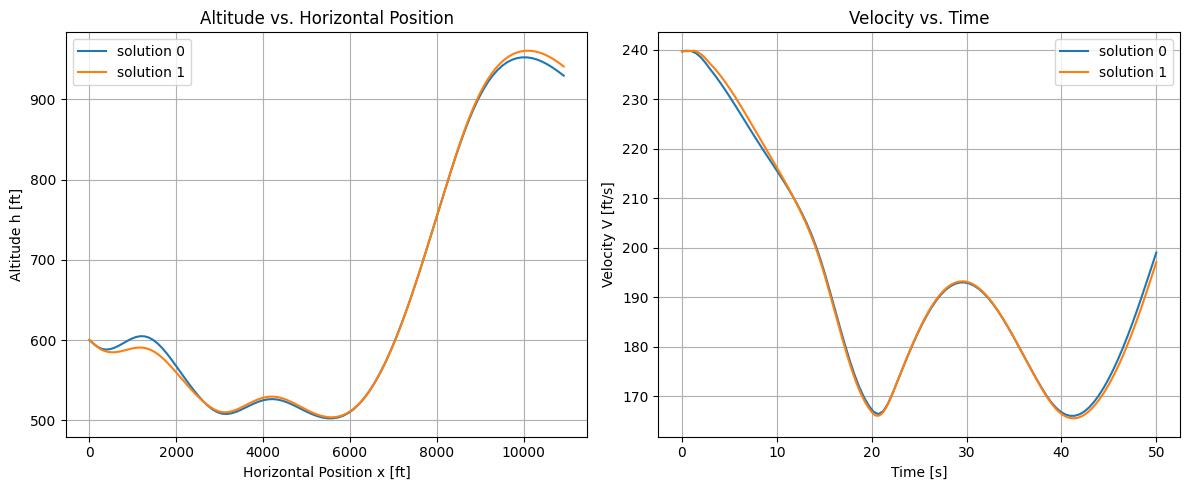

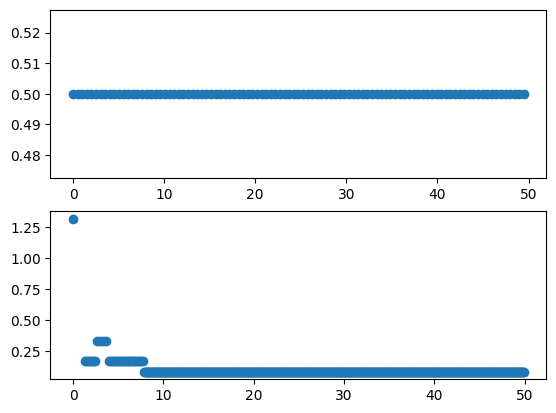

In [11]:
t_grid_original = np.linspace(0, tf, 100)
res_original = solve_ocp(t_grid_original, k_values[0], s_values[0])
res_new = solve_ocp(t_grid_new, k_values[0], s_values[0])
plot_trajectories([res_original, res_new], [t_grid_original, t_grid_new], k_values[0], s_values[0])
dt_original = np.ones(len(t_grid_original) - 1) * tf / 100
dt_new = np.array([t_grid_new[i + 1] - t_grid_new[i] for i in range(len(t_grid_new) - 1)])
fig, axs = plt.subplots(2, 1)
axs[0].scatter(t_grid_original[:-1], dt_original)
axs[1].scatter(t_grid_new[:-1], dt_new)
plt.show()

### Performance on cosh wind model

In [12]:
def plot_trajectories(solutions, t_grids, k_val, s_val):
        
    plt.figure(figsize=(12,5))

    # h-x plot
    plt.subplot(1,2,1)
    for i in range(len(solutions)):
        sol = solutions[i]
        t_grid = t_grids[i]
        x = sol['x'] 
        h = sol['h']
        print(f"Solution {i+1} minimum altitude: {np.min(h):4f} ft")
        plt.plot(x, h, label=f'solution {i}')
        
    plt.xlabel('Horizontal Position x [ft]')
    plt.ylabel('Altitude h [ft]')
    plt.title('Altitude vs. Horizontal Position')
    plt.grid(True)
    plt.legend()

    # V-t plot
    plt.subplot(1,2,2)
    for i in range(len(solutions)):
        sol = solutions[i]
        t_grid = t_grids[i]
        V = sol['V']
        plt.plot(t_grid, V, label=f'solution {i}')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity V [ft/s]')
    plt.title('Velocity vs. Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def solve_ocp_cosh_wind(t_grid, k_value, s_value):
    N = len(t_grid) - 1
    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(N+1)
    h_s = opti.variable(N+1)
    V_s = opti.variable(N+1)
    gamma_s = opti.variable(N+1)
    alpha_s = opti.variable(N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    def A_cosh(x, e=1):
        m = 1/40
        a = 2000
        c = 2300 * e
        d = 150
        f = 50*d / (2*e*a) * (
            ca.log(ca.cosh( ((x-(c)) + e*a) / d)) 
            - ca.log(ca.cosh( ((x-(c)) - e*a) / d))
            )
        return f

    def B_cosh(x, e=1):
        a = 1150**2
        c = 1350**2
        d = 630**2
        l = 2300 * e
        f = -25.5 + 25.5*(d*e)  /(2*e*a) * (
            ca.log(ca.cosh( ((x - l)**2 - e**2*c + e**2*a) / (d*e**2))) 
            - ca.log(ca.cosh( ((x - l)**2 - e**2*c - e**2*a) / (d*e**2))) 
            )
        return f

    def wind_x(x_, k_, s_):
        return k_ * A_cosh(x_, s_)

    def wind_h(x_, h_, k_, s_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_cosh(x_, s_)

    def dx_A_cosh(x, e=1):
        m = 1/40
        a = 2000
        c = 2300 * e
        d = 150
        f = 50 / (2*e*a) * (
            (1 / (ca.cosh( ((x-(c)) + e*a) / d))) * ca.sinh(((x-(c)) + e*a) / d)
            - (1 / (ca.cosh( ((x-(c)) - e*a) / d))) * ca.sinh(((x-(c)) - e*a) / d)
            )
        return f

    def dx_B_cosh(x, e=1):
        a = 1150**2
        c = 1350**2
        d = 630**2
        l = 2300 * e
        f = 25.5 /(2*e*a) * (
            (1/(ca.cosh( ((x - l)**2 - e**2*c + e**2*a) / (d*e**2)))) * ca.sinh(((x - l)**2 - e**2*c + e**2*a) / (d*e**2)) * 2 *(x-l)
            - (1/(ca.cosh( ((x - l)**2 - e**2*c - e**2*a) / (d*e**2)))) * ca.sinh(((x - l)**2 - e**2*c - e**2*a) / (d*e**2)) * 2 *(x-l) 
            )
        return f
    
    def dx_wind_x(x_, k_, s_):
        return k_ * dx_A_cosh(x_, s_)

    def dx_wind_h(x_, h_, k_, s_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * dx_B_cosh(x_, s_)

    def dh_wind_h(x_, h_, k_, s_):
        return k_ / h_star * B_cosh(x_, s_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_):
        return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x(x_sym, k_value, s_value)
    Wh_expr = wind_h(x_sym, h_sym, k_value, s_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [dx_wind_x(x_sym, k_value, s_value)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [dx_wind_h(x_sym, h_sym, k_value, s_value)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [dh_wind_h(x_sym, h_sym, k_value, s_value)])

    def aircraft_ode(X, u_, t_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        
        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2
        
        Wx = wind_x(x_, k_value, s_value)
        Wh = wind_h(x_, h_, k_value, s_value)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt):
        k1 = f(xk, uk, tk)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
        k4 = f(xk + dt * k3, uk, tk + dt)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # Initial conditions
    opti.subject_to(x_s[0] == 0)
    opti.subject_to(h_s[0] == 600 / hscale)
    opti.subject_to(V_s[0] == 239.7 / Vscale)
    opti.subject_to(V_s[:] >= 1e-2 / Vscale)
    opti.subject_to(gamma_s[0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[0] == min(0.1283, alphascale) / alphascale)
    opti.subject_to(gamma_s[-1] == -0.05236 / gammascale)

    for i in range(N):
        tk = t_grid[i]
        dt = t_grid[i + 1] - t_grid[i]

        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt)
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        opti.subject_to(X_next == Xk_end)
        opti.subject_to(opti.bounded(-1, u_s[i], 1))
        opti.subject_to(opti.bounded(-1, alpha_s[i], 1))

    # Cost function
    J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    opti.set_initial(x_s, ca.linspace(0, 1, N+1))
    opti.set_initial(h_s, 0.6)
    opti.set_initial(V_s, 239.7 / Vscale)
    opti.set_initial(gamma_s, -0.01 / gammascale)
    opti.set_initial(alpha_s, 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opti.solver("ipopt", {"expand": True}, {
        "max_iter": 1000,
        "tol": 1e-6,
        "print_level": 0,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory",
    })

    try:
        # opti.callback(lambda i: print("Alpha max:", np.max(opti.debug.value(alpha_s))))
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        raise e

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }

In [17]:
k_values = [1, 1.3]
s_values = [1, 0.9]
tf = 5

tol = 0.01
order = 4
max_iterations = 5

N_init = 10
t_grid_init = np.linspace(0, tf, N_init)

N_old = N_init
N_new = N_init
iteration = 0
t_grid_new = t_grid_init

while iteration < max_iterations and not (N_old == N_new and iteration != 0):
    N_old = N_new
    t_grid_old = t_grid_new
    res_old = []
    for i in range(len(k_values)):
        res_old_entry = solve_ocp_cosh_wind(t_grid_old, k_values[i], s_values[i])
        res_old.append(res_old_entry)

    t_grid_compare = reduceIntervalBy2(t_grid_old)
    res_compare = []
    for i in range(len(k_values)):
        res_compare_entry = solve_ocp_cosh_wind(t_grid_compare, k_values[i], s_values[i])
        res_compare.append(res_compare_entry)

    t_grid_new = refineSolution(res_old, res_compare, t_grid_old, t_grid_compare, tol=tol, p=order)
    N_new = len(t_grid_new)
    print('N_old: ', N_old)
    print('N_new: ', N_new)
    print("\n")
    iteration += 1

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  39.00us (  3.55us)  50.26us (  4.57us)        11
       nlp_g  | 610.00us ( 55.45us) 593.15us ( 53.92us)        11
  nlp_grad_f  |  46.00us (  3.83us)  44.30us (  3.69us)        12
   nlp_jac_g  |   2.34ms (195.42us)   2.37ms (197.11us)        12
       total  |  30.89ms ( 30.89ms)  30.90ms ( 30.90ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  55.00us (  5.00us)  43.81us (  3.98us)        11
       nlp_g  | 710.00us ( 64.55us) 685.86us ( 62.35us)        11
  nlp_grad_f  |  51.00us (  4.25us)  47.71us (  3.98us)        12
   nlp_jac_g  |   2.79ms (232.33us)   2.82ms (235.26us)        12
       total  |  32.66ms ( 32.66ms)  33.07ms ( 33.07ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  49.00us (  4.08us)  39.72us (  3.31us)        12
       nlp_g  | 996.00us ( 83.00us) 976.46us ( 81.37us)        12
  nlp_grad

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  66.00us (  5.08us)  62.08us (  4.78us)        13
       nlp_g  |   5.53ms (425.23us)   5.54ms (426.01us)        13
  nlp_grad_f  | 123.00us (  8.79us) 117.29us (  8.38us)        14
   nlp_jac_g  |  27.53ms (  1.97ms)  27.57ms (  1.97ms)        14
       total  | 174.27ms (174.27ms) 174.29ms (174.29ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 202.00us (  8.78us) 194.26us (  8.45us)        23
       nlp_g  |  19.59ms (851.57us)  19.67ms (855.16us)        23
  nlp_grad_f  | 294.00us ( 15.47us) 273.44us ( 14.39us)        19
   nlp_jac_g  |  76.72ms (  4.04ms)  77.15ms (  4.06ms)        19
       total  | 470.53ms (470.53ms) 472.64ms (472.64ms)         1
Solution 1 minimum altitude: 568.528514 ft
Solution 2 minimum altitude: 568.323257 ft


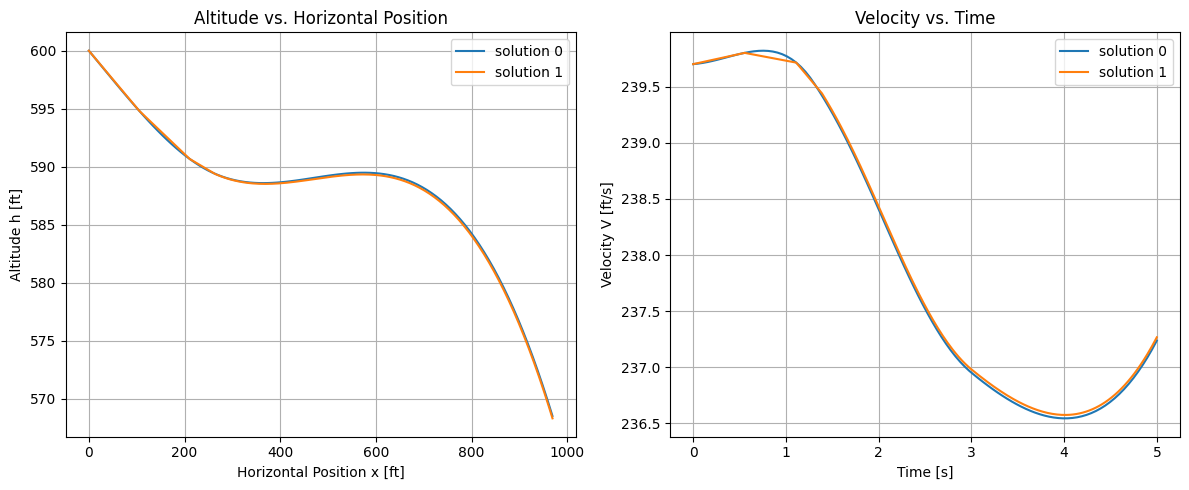

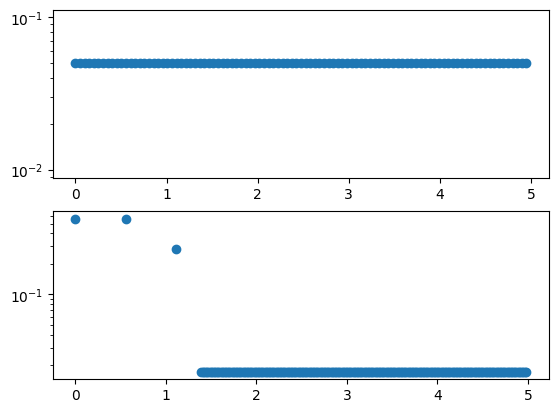

In [18]:
t_grid_original = np.linspace(0, tf, 100)
res_original = solve_ocp_cosh_wind(t_grid_original, k_values[0], s_values[0])
res_new = solve_ocp_cosh_wind(t_grid_new, k_values[0], s_values[0])
plot_trajectories([res_original, res_new], [t_grid_original, t_grid_new], k_values[0], s_values[0])
dt_original = np.ones(len(t_grid_original) - 1) * tf / 100
dt_new = np.array([t_grid_new[i + 1] - t_grid_new[i] for i in range(len(t_grid_new) - 1)])
fig, axs = plt.subplots(2, 1)
axs[0].scatter(t_grid_original[:-1], dt_original)
axs[0].set_yscale('log')
axs[1].scatter(t_grid_new[:-1], dt_new)
axs[1].set_yscale('log')
plt.show()